In [1]:
import h5py
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (
    EarlyStopping,
    LearningRateScheduler,
    LambdaCallback,
)
from sklearn.preprocessing import StandardScaler  # for scaling input and output data
from sklearn.preprocessing import RobustScaler  # for scaling input and output data
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d, make_interp_spline
import argparse
from sklearn.decomposition import PCA
from tensorflow.keras.models import load_model
from tqdm import tqdm
import pickle
from classy import Class
from train_pybird_emulators.emu_utils import integrated_model
from train_pybird_emulators.emu_utils import emu_utils
from cosmic_toolbox import logger
from train_pybird_emulators.emu_utils.k_arrays import k_emu, k_pybird

2024-10-16 05:55:25.953329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 05:55:26.754017: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 05:55:27.024376: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 05:55:28.537531: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 05:55:50.740618: W tensorflow/compiler/tf2

loading loop matrices!


In [2]:
piece_name = "Ploopl"
model_name = "test_ploopl"
ntrain=200000
mono=True
quad_hex=False
mask_high_k=False
quad_alone=False
hex_alone=False
k_array_length = 77
training_data_file = "/cluster/scratch/areeves/pybird_training_data_pybird_gc/total_data.h5"

In [3]:
cov = emu_utils.get_default_cov()
print("cov shape", cov.shape)
flattened_rescale_factor = np.diag(cov)

cov shape (231, 231)


In [4]:
x_train, y_train = emu_utils.get_training_data_from_hdf5(
    training_data_file,
    piece_name,
    ntrain,
    mono,
    quad_hex,
    quad_alone,
    hex_alone,
    mask_high_k
)

24-10-16 05:57:00 train_pybi INF   total number of available training points: 2394400 
24-10-16 05:57:00 train_pybi INF   Available keys in the file: <KeysViewHDF5 ['IRPs11', 'IRPsct', 'IRPsloop', 'P11l', 'Pctl', 'Ploopl', 'params']> 
24-10-16 05:57:09 train_pybi INF   Using monopole data for Ploopl 
where are zeros?
(array([   0,   77,  154,  231,  308,  385,  462,  539,  616,  693,  770,
        847,  924, 1001, 1078, 1155, 1232, 1309, 1386, 1463, 1540, 1617,
       1694, 1771, 1848, 1925, 2002, 2079, 2156, 2233, 2310, 2387, 2464,
       2541, 2618, 2695, 2772, 2849, 2926, 3003, 3080, 3157, 3234, 3311,
       3388, 3465, 3542, 3619, 3696, 3773, 3850, 3927, 4004, 4081, 4158,
       4235, 4312, 4389, 4390, 4391, 4392, 4393, 4394, 4395, 4396, 4466,
       4467, 4468, 4469, 4470, 4471, 4472, 4473, 4543, 4620, 4697, 4774,
       4775, 4776, 4777, 4778, 4779, 4780, 4781, 4851, 4928, 4929, 4930,
       4931, 4932, 4933, 4934, 4935, 5005, 5006, 5007, 5008, 5009, 5010,
       5011, 5012, 5082

In [5]:
# print(f"filtering out bad indices for piece {piece_name}")

condition_1 = np.any(x_train[:, :-2] > 0, axis=1)
condition_2 = x_train[:, -1] < 0
condition_3 = x_train[:, -2] < 0
bad_inds = np.where(condition_1 | condition_2 | condition_3)[0]

# # bad_inds = np.where(condition_1 | condition_2 | condition_3 | condition_4)[0]

# #ensure that the gradients in the first 10 knots are not consecutively negative 
# # New condition: Two consecutive negative gradients in the first 10 positions
# # Compute gradients in the first 10 positions
gradients_first_5 = np.diff(x_train[:, :6], axis=1)  # Shape: (num_samples, 10)

# # # Identify negative gradients
negative_gradients = gradients_first_5 < 0  # Shape: (num_samples, 10)
condition_4 = np.any(negative_gradients, axis=1)


bad_inds = np.where(condition_1 | condition_2 | condition_3 | condition_4)[0]


# if piece_name.startswith("I"):
#     print("training IR piece... going to filter out large gradients")
    # Calculate the absolute gradients along each row
gradients = np.abs(np.diff(y_train, axis=1))

gradient_threshold = np.quantile(
    gradients, 0.95
)  # top 15% of gradients

# spikes typically happen around high k
spike_positions = np.arange(
    k_emu.shape[0] - 1, gradients.shape[1], k_emu.shape[0]
)  # Adjust for 0-index and diff output size

# Condition to identify rows with gradient spikes at specific positions
condition_5= np.any(
    gradients[:, spike_positions] > gradient_threshold, axis=1
)


bad_inds = np.where(
    condition_1 | condition_2 | condition_3 
)[0]


    

print(f"removing {len(bad_inds)} bad indices")
x_train = np.delete(x_train, bad_inds, axis=0)
y_train = np.delete(y_train, bad_inds, axis=0)

removing 2624 bad indices


In [6]:
# print(np.where(condition_4))

In [7]:
x_train.shape 

(197376, 82)

(-100.0, 300000.0)

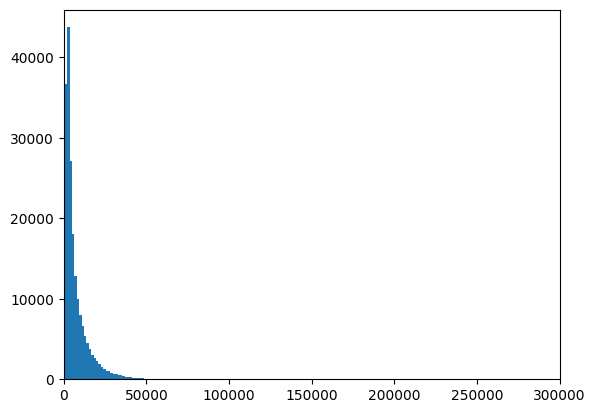

In [8]:
plt.hist(x_train[:,-2], bins=100)
plt.xlim(-100,300000)

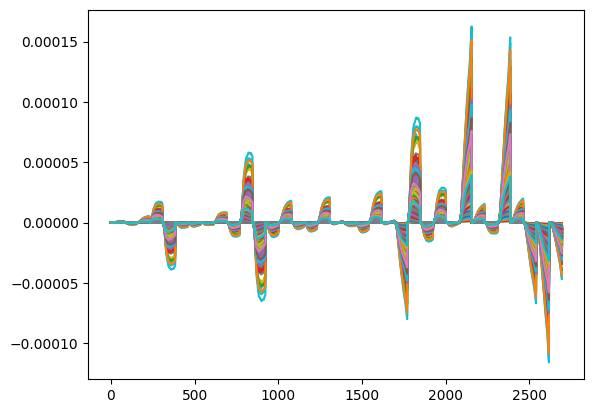

In [9]:
for i in range(650): 
    plt.plot(y_train[i])

In [10]:
np.where(np.abs(y_train)==np.amax(np.abs(y_train)))

(array([180301]), array([2155]))

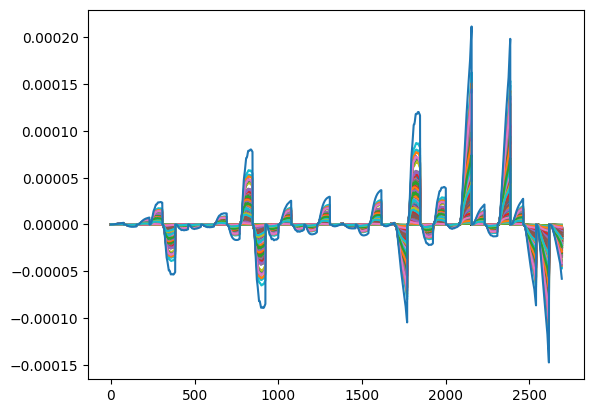

In [11]:
for i in range(1000): 
    plt.plot(y_train[i])
plt.plot(y_train[np.where(np.abs(y_train)==np.amax(np.abs(y_train)))[0][0]])

In [12]:
y_train.shape 

(197376, 2695)

In [13]:
max_params= x_train[np.where(np.abs(y_train)==np.amax(np.abs(y_train)))[0]]

In [14]:
knots = np.load("/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/knots_data/final_knots_80.npy")

In [15]:
print(knots[0:6])

[0.0001     0.000146   0.00021317 0.00031123 0.0004544  0.00066343]


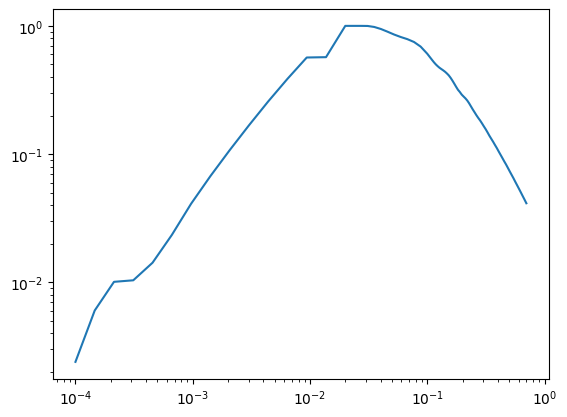

In [16]:
plt.loglog(knots, np.exp(max_params[0, :80]))

In [17]:
print(max_params[0, -2])

1152.7285573983152


In [18]:
if flattened_rescale_factor is not None:
    num_patterns = y_train.shape[1] // k_array_length
    rescaling_factor = emu_utils.generate_repeating_array(
        flattened_rescale_factor, 77, num_patterns // 3
    )
    if mono:
        rescaling_factor = emu_utils.generate_repeating_array(
            flattened_rescale_factor, 77, num_patterns
        )
        rescaling_factor = rescaling_factor[: 35 * 77]
    if quad_hex:
        rescaling_factor = emu_utils.generate_repeating_array(
            flattened_rescale_factor, 77, 35
        )
        rescaling_factor = rescaling_factor[35 * 77 :]
    if not mono and not quad_hex:
        rescaling_factor = rescaling_factor
    rescaling_factor = np.array(rescaling_factor)
else:
    rescaling_factor = None

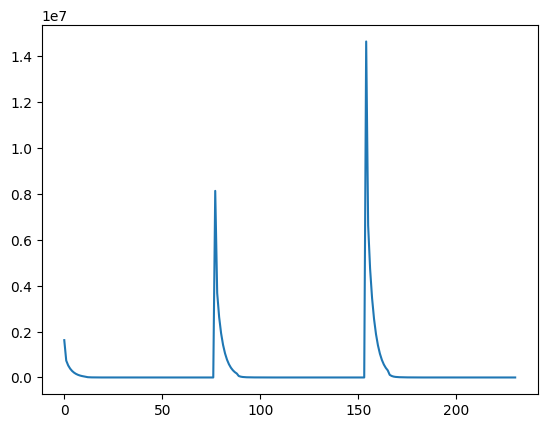

In [19]:
plt.plot(flattened_rescale_factor)

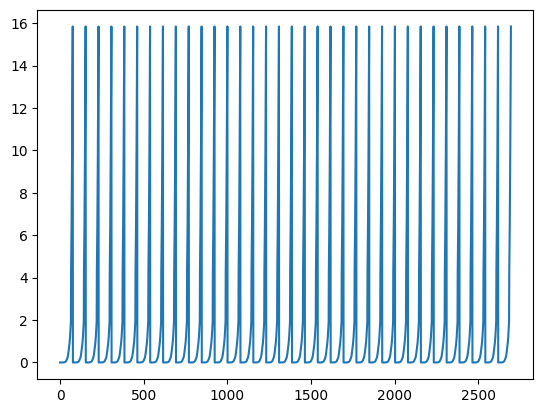

In [20]:
plt.plot(1/rescaling_factor)

In [21]:
# Are there places where all the columns in the data are zero?
zero_columns = np.where(np.sum(np.abs(y_train), axis=0) == 0)[0]

if zero_columns is not None and zero_columns.shape[0] > 0:
    # LOGGER.info(f"removing zero columns for piece {args.piece_name}")
    # remove and save zero columns indices
    np.save(f"zero_coumns_{piece_name}", zero_columns)
    y_train = np.delete(y_train, zero_columns, axis=1)
    if rescaling_factor is not None:
        rescaling_factor = np.delete(rescaling_factor, zero_columns, axis=0)

In [22]:
# print("using PCA preprocessing")
# npca=512
# pca_scaler = StandardScaler().fit(y_train)
# pca = PCA(n_components=npca)
# # Fit PCA to standard scaled data
# normalized_data = pca_scaler.transform(y_train)
# pca.fit(normalized_data)
# y_train = pca.transform(normalized_data)
# rescaling_factor = np.power(
#     pca.explained_variance_, -1
# )  # default for PCA is to use the explained variance to weight the components
# print(f"explained variance: {np.sum(pca.explained_variance_ratio_)}")
# print("using explained variance to weight the components")
# rescaling_factor = np.array(rescaling_factor)

In [23]:
# print("Log prepocessing")
# offset = np.amin(y_train, axis=0)
# offset[offset > 0] = 0
# y_train = np.log(y_train - 2 * offset)

In [24]:
input_scaler = StandardScaler().fit(x_train)
output_scaler = StandardScaler().fit(y_train)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

keras_model = integrated_model.create_model(
    input_dim=x_train.shape[1],
    hidden_layers=[256,256,256,256],
    output_dim=y_train.shape[1],
)

x_train shape: (197376, 82)
y_train shape: (197376, 2660)


2024-10-16 05:57:41.836630: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22996 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5


In [25]:
# Initialize model and train
model = integrated_model.IntegratedModel(
    keras_model,
    input_scaler=input_scaler,
    output_scaler=output_scaler,
    offset=None,
    log_preprocess=False,
    temp_file=f"saved_models/{model_name}_temp",
    pca=None,
    pca_scaler=None,
    zero_columns=zero_columns,
    rescaling_factor=1.,
)
model.train(
    x_train,
    y_train,
    epochs=600,
    batch_size=2048,
    validation_split=0.2,
)


Training with learning rate: 0.001


  0%|          | 0/600 [00:00<?, ?epoch/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1729051078.447748 4148067 service.cc:146] XLA service 0xa23afd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729051078.447797 4148067 service.cc:154]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2024-10-16 05:58:03.459970: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-16 05:58:11.234750: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1729051094.814190 4148067 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 600/600 [07:34<00:00,  1.40epoch/s, train_loss=3.2114e-03, val_loss=3.3739e-03]

Restoring model weights from the end of the best epoch: 598.


100%|██████████| 600/600 [07:34<00:00,  1.32epoch/s, train_loss=3.2114e-03, val_loss=3.3739e-03]



Training with learning rate: 0.0005


 97%|█████████▋| 581/600 [07:00<00:13,  1.38epoch/s, train_loss=3.1750e-03, val_loss=2.4109e-03]


KeyboardInterrupt: 

In [ ]:
n_train=5000

In [ ]:
x_test, y_test = emu_utils.get_training_data_from_hdf5(
    training_data_file,
    piece_name,
    n_train,
    mono,
    quad_hex,
    quad_alone, 
    hex_alone,
    mask_high_k,
    test_data=True
)

In [ ]:
x_test

In [ ]:
print(f"filtering out bad indices for piece {piece_name}")

condition_1 = np.any(x_test[:, :-2] > 0, axis=1)
condition_2 = x_test[:, -1] < 0
condition_3 = x_test[:, -2] < 0
condition_4 = x_test[:, -2] > 20000
gradients_first_10 = np.diff(x_test[:, :11], axis=1)  # Shape: (num_samples, 10)

# Identify negative gradients
negative_gradients = gradients_first_10 < 0  # Shape: (num_samples, 10)

# Find two consecutive negative gradients
neg_gradients_original = negative_gradients[:, :-1]  # Exclude last element
neg_gradients_shifted = negative_gradients[:, 1:]    # Exclude first element

consecutive_negatives = neg_gradients_original & neg_gradients_shifted  # Shape: (num_samples, 9)

# Condition 6: Samples with two consecutive negative gradients in first 10 positions
condition_5 = np.any(negative_gradients, axis=1)

bad_inds = np.where(condition_1 | condition_2 | condition_3 | condition_4 | condition_5)[0]



if piece_name.startswith("I"):
    print("training IR piece... going to filter out large gradients")
    # Calculate the absolute gradients along each row
    gradients = np.abs(np.diff(y_test, axis=1))
    
    gradient_threshold = np.quantile(
        gradients, 0.80
    )  # top 15% of gradients
    
    # spikes typically happen around high k
    spike_positions = np.arange(
        k_emu.shape[0] - 1, gradients.shape[1], k_emu.shape[0]
    )  # Adjust for 0-index and diff output size
    
    # Condition to identify rows with gradient spikes at specific positions
    condition_5= np.any(
        gradients[:, spike_positions] > gradient_threshold, axis=1
    )
    
    
    bad_inds = np.where(
        condition_1 | condition_2 | condition_3 | condition_5 
    )[0]

print(f"removing {len(bad_inds)} bad indices")
x_test = np.delete(x_test, bad_inds, axis=0)
y_test = np.delete(y_test, bad_inds, axis=0)

In [ ]:
model.save(f"test_models/{model_name}")


In [ ]:
test_model = integrated_model.IntegratedModel(None,None,None,None)

In [ ]:
test_model.restore(f"test_models/{model_name}")

In [ ]:
# with open("/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/notebooks/test_models/test_ploopl.pkl", "rb") as f:
#     attributes = pickle.load(f)

In [ ]:
test_model.log_preprocess = False 
predicted_testing_spectra = test_model.predict(x_test)
# predicted_testing_spectra = model.predict(x_test)

testing_spectra = y_test


In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(16,20))
for j in range(5):
    for i in range(5):
        pred = predicted_testing_spectra[i+j*3]
        true = testing_spectra[i+j*3]
        ell_range = np.arange(true.shape[0])
        ax[j, i].plot(ell_range, true, 'blue', label = 'Original')
        ax[j, i].plot(ell_range, pred, 'red', label = 'NN reconstructed', linestyle='--')
        ax[j, i].set_xlabel('$\ell$', fontsize='x-large')
        ax[j, i].set_ylabel('$\\frac{[\ell(\ell+1)]^2}{2 \pi} C_\ell$', fontsize='x-large')
        ax[j, i].legend(fontsize=15)


In [ ]:
(1-np.median(np.abs((testing_spectra[:, ~zero_columns]-predicted_testing_spectra[:, ~zero_columns])/testing_spectra[:, ~zero_columns])))*100